In [374]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.metrics import fbeta_score
from scipy.stats import norm
from matplotlib import gridspec


from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project'

## Toy dataset for regression

In [2]:
W = np.array([-10, 10]).reshape(-1, 1)
b = -5
X_train = np.random.uniform(-10,10, (5000, 2))
X_train[:,0] = 0.0
X_train.shape
W.T.shape

eps = 0.0001
W_s = np.array([0.0, 0.3]).reshape(-1, 1)
print(W_s)
b_s = 0.1

print(b_s)

y_train = np.zeros((X_train.shape[0], 1), dtype=float)
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  y_train[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))



print(y_train)

[[0. ]
 [0.3]]
0.1
[[ 14.03725101]
 [-61.50776828]
 [  8.98076456]
 ...
 [  2.3634371 ]
 [-50.50836559]
 [  4.06785872]]


(array([642., 680., 564., 617., 633., 636., 667., 425., 123.,  13.]),
 array([-105.02528403,  -80.06896611,  -55.11264818,  -30.15633025,
          -5.20001232,   19.7563056 ,   44.71262353,   69.66894146,
          94.62525938,  119.58157731,  144.53789524]),
 <a list of 10 Patch objects>)

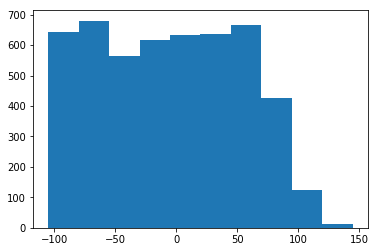

In [3]:
plt.hist(y_train)
# np.exp(10 * 0.01)

compare likelihood of test set given true mean and true variance and true variance + bias

In [4]:
tst = np.empty_like(X_train[:,0])
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  tst[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
tst

print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s)).sum())
print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s) + 100).sum())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

Toy dataset for classification 2d

In [205]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
# X_train[:,0] = np.random.normal(loc=0,
#                                 scale=1,
#                                 size=(int(dataset_size),))
# X_train[:, 1] = np.random.normal(loc=0, 
#                                  scale=1, 
#                                  size=(int(dataset_size),))

# X_train[:, 0] = np.random.uniform(2, 12, 
#                                   size=(int(dataset_size),))
# X_train[:, 1] = np.random.uniform(-5, 5,
#                                   size=(int(dataset_size),))
X_train[:, 0] = 0
X_train[:, 1] = np.random.uniform(-10, 10, 
                                  size=(int(dataset_size),))



# scale = 1

# X_train[:int(dataset_size/2), 0] = np.random.uniform(2 * scale, 12 * scale, 
#                                                     size=(int(dataset_size/2),))
# X_train[:int(dataset_size/2), 1] = np.random.uniform(7.5* scale, 13.5 * scale,
#                                                    size=(int(dataset_size/2),))


# y_train[:int(dataset_size/2)] = 0

# X_train[int(dataset_size/2):,0] = np.random.uniform(2 * scale - 10, 12 * scale - 10,
#                                                    size=(int(dataset_size/2),))
# X_train[int(dataset_size/2):, 1] = np.random.uniform(0.5 * scale + 1, 6.5 * scale + 1,
#                                                     size=(int(dataset_size/2),))
# y_train[int(dataset_size/2):] = 1

# # shuffle order
# perm = np.random.permutation(dataset_size)
# X_train = X_train[perm]
# y_train = y_train[perm]

In [206]:
# A = np.array([[1, 1],
#               [1, 0]])
# X_train = X_train @ A

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


array([[ 0.        ,  0.94081762],
       [ 0.        ,  7.13378111],
       [ 0.        ,  7.19367727],
       ...,
       [ 0.        ,  4.35090046],
       [ 0.        , -1.30341232],
       [ 0.        ,  9.55301424]])

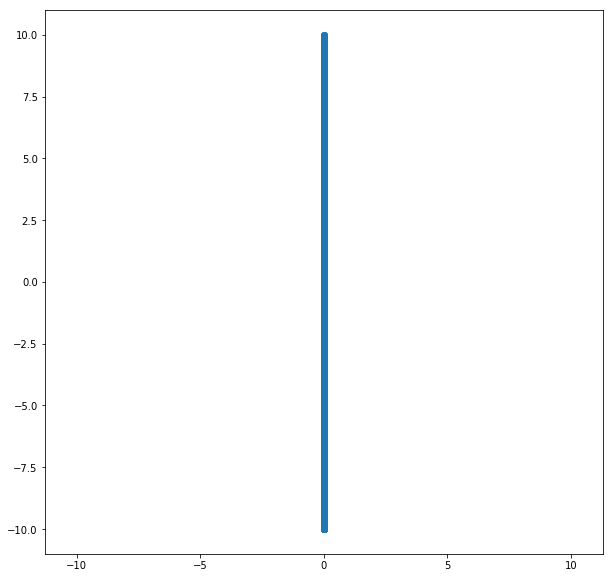

In [207]:

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)   
ax.scatter(X_train[:,0], X_train[:,1])
ax.axis('equal')
fig.show()
X_train

In [179]:
np.log(0.1)

-2.3025850929940455

In [208]:
# for this case are we having the same thing where the variance is still a product of both dimensions
# so W isn't going where we expect?
for i, row_i in enumerate(X_train):
    # want b2=0 and w2_1=0.08
    X_train[i, 0] = np.random.normal(loc=0, scale=np.exp(0.2 * X_train[i, 1]))
#     X_train[i, 0] = X_train[i, 0] + np.random.normal(loc=0, scale= np.exp(0.1 * X_train[i, 1]))
#     X_train[i, 1] = X_train[i, 1] + np.random.normal(loc=0, scale= np.exp(0.03 * X_train[i, 1]))


unbiased sample STD between 1 and -9: 0.3263867195950278
unbiased sample STD between 1 and -8: 0.3291324541622995
unbiased sample STD between 1 and -7: 0.3615216962009928
unbiased sample STD between 1 and -6: 0.4009028397826894
unbiased sample STD between 1 and -5: 0.43285514261526337
unbiased sample STD between 1 and -4: 0.49684007234195293
unbiased sample STD between 1 and -3: 0.6118160557344372
unbiased sample STD between 1 and -2: 0.74273779255733
unbiased sample STD between 1 and -1: 0.7794290694796585
unbiased sample STD between 1 and 0: 0.982902723971343
unbiased sample STD between 1 and 1: 1.175867540536861
unbiased sample STD between 1 and 2: 1.3458333970212668
unbiased sample STD between 1 and 3: 1.5748899595955868
unbiased sample STD between 1 and 4: 1.9905123345644185
unbiased sample STD between 1 and 5: 2.5165892165051598
unbiased sample STD between 1 and 6: 2.8065024074838694
unbiased sample STD between 1 and 7: 3.9210336043689282
unbiased sample STD between 1 and 8: 4.09

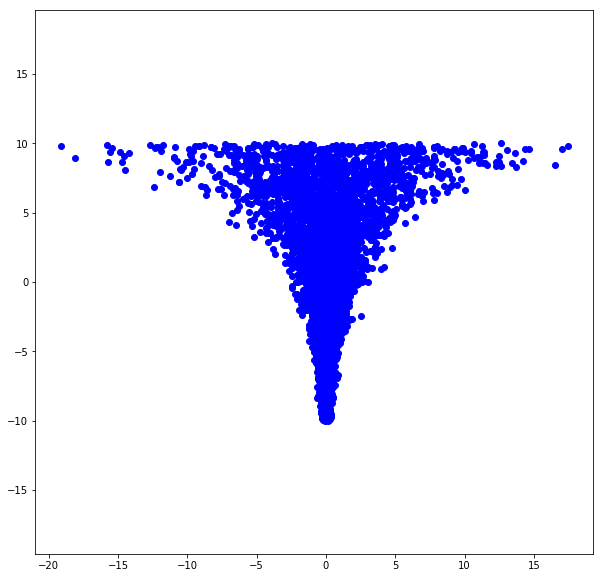

In [312]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[:,0], X_train[:,1], c='blue')
# ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()

for i in range(-10, 10):
    samp = X_train[(X_train[:,1] >= i) & (X_train[:,1] < i + 1)]
    mean = samp.mean(axis=0)
    samp_var = 1 / samp.shape[0] * np.sum(np.linalg.norm(samp - mean)**2 , axis=0)
    print('unbiased sample STD between {} and {}: {}'.format(1, i + 1, np.sqrt(samp_var)))
    

# samp = X_train[X_train[:,1] < -5]
# mean = samp.mean(axis=0)
# samp_var = 1 / samp.shape[0] * np.sum(np.linalg.norm(samp - mean)**2 , axis=0)
# print('unbiased sample variance: ', samp_var)

# samp = X_train[(X_train[:,1] >= -5) & (X_train[:,1] < 0)]
# mean = samp.mean(axis=0)
# samp_var = 1 / samp.shape[0] * np.sum(np.linalg.norm(samp - mean)**2 , axis=0)
# print('unbiased sample variance: ', samp_var)

# samp = X_train[(X_train[:,1] >= 0) & (X_train[:,1] < 5)]
# mean = samp.mean(axis=0)
# samp_var = 1 / samp.shape[0] * np.sum(np.linalg.norm(samp - mean)**2 , axis=0)
# print('unbiased sample variance: ', samp_var)

# samp = X_train[(X_train[:,1] >= 5) & (X_train[:,1] < 10)]
# mean = samp.mean(axis=0)
# samp_var = 1 / samp.shape[0] * np.sum(np.linalg.norm(samp - mean)**2 , axis=0)
# print('unbiased sample variance: ', samp_var)

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


sklearn logistic regression accuracy is: 0.919


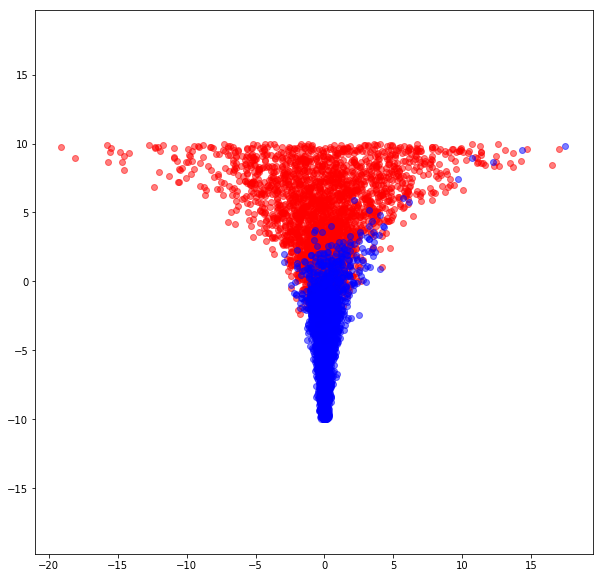

In [224]:
# Create classes by rule: 
# x in class 0 if x2 >= 0.8 * x1 + np.random.normal(0, 0.3) else in class 1


dec_boundry = X_train[:, 0] * 0.5 + np.random.normal(0, 1.8, size=(X_train[:,0].shape))
y_train[X_train[:,1] >= dec_boundry] = 0
y_train[X_train[:,1] < dec_boundry] = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='red', alpha=0.5)
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='blue', alpha=0.5)
ax.axis('equal')
fig.show()
y_train

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('sklearn logistic regression accuracy is:', lr.score(X_train, y_train))

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Pytorch/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


sklearn logistic regression accuracy is: 1.0
sklearn logistic regression accuracy is: 0.8922


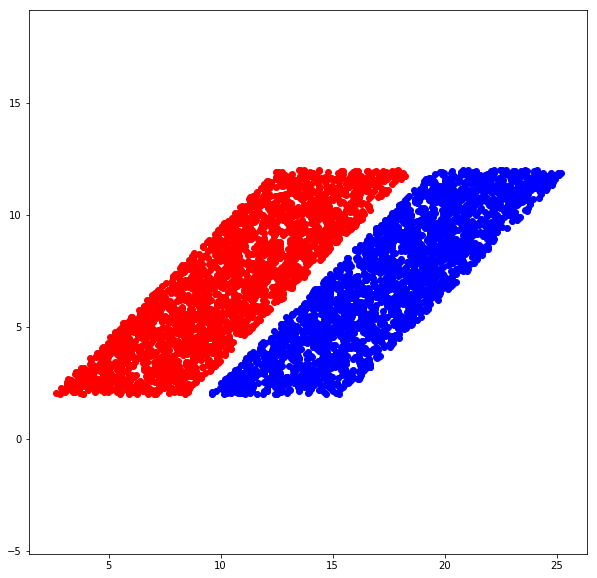

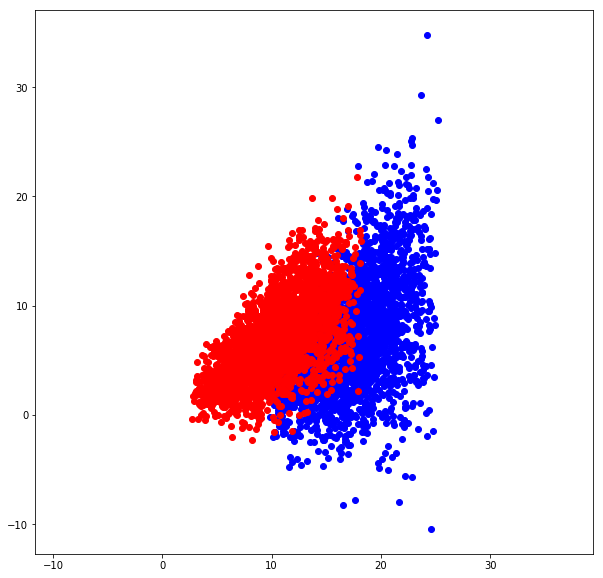

In [212]:
dataset_size = 5000

X_test = np.empty(shape=(dataset_size, 2), dtype=float)
y_test = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
# X_test[:int(dataset_size/2),0] = np.random.normal(loc=0,
#                                                    scale=1,
#                                                    size=(int(dataset_size/2),))
# X_test[:int(dataset_size/2), 1] = np.random.normal(loc=0, 
#                                                     scale=1, 
#                                                     size=(int(dataset_size/2),))

scale = 1

X_test[:int(dataset_size/2), 0] = np.random.uniform(2 * scale, 12 * scale, 
                                                    size=(int(dataset_size/2),))
X_test[:int(dataset_size/2), 1] = np.random.uniform(7.5* scale, 13.5 * scale,
                                                   size=(int(dataset_size/2),))


y_test[:int(dataset_size/2)] = 0

X_test[int(dataset_size/2):,0] = np.random.uniform(2 * scale, 12 * scale,
                                                   size=(int(dataset_size/2),))
X_test[int(dataset_size/2):, 1] = np.random.uniform(0.5 * scale, 6.5 * scale,
                                                    size=(int(dataset_size/2),))
y_test[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_test = X_test[perm]
y_test = y_test[perm]

A = np.array([[1, 1],
              [1, 0]])
X_test = X_test @ A

def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b
    

w1 = np.array([[0,0]]).T
w2 = np.array([[0,0]]).T
W_full = np.hstack((w1, w2))
b = 0

x = y = np.arange(-8.0, 8.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = plane(X, Y, w1, b)
# print("X shape", zs.shape)

# Z = zs.reshape(X.shape)

# ax.plot_surface(X, Y, Z)

# x_line = np.random.uniform(-8, 8, (100, 2))
#  = 
# print(w1.T.shape)
# y = w1.T @ x + b
# y = y.flatten()
# plt.plot(x1, x2)
# plt.scatter(X_test[y_test == 0,0], X_test[y_test == 0,1], c='red', alpha=0.2)
# plt.scatter(X_test[y_test == 1,0], X_test[y_test == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))


fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(311, projection='3d')       
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_test[y_test == 0,0], X_test[y_test == 0,1], c='blue')
ax.scatter(X_test[y_test == 1,0], X_test[y_test == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_test, y_test)
print('sklearn logistic regression accuracy is:', lr.score(X_test, y_test))

for i, row_i in enumerate(X_test):
    X_test[i, 1] = X_test[i, 1] + np.random.normal(loc=0, scale= np.exp(0.08 * X_test[i, 0]))
    
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_test, y_test)
print('sklearn logistic regression accuracy is:', lr.score(X_test, y_test))

fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(311, projection='3d')       
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_test[y_test == 0,0], X_test[y_test == 0,1], c='blue')
ax.scatter(X_test[y_test == 1,0], X_test[y_test == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()

plt.savefig("toy_classification.png")

Toy dataset for classification 1d

Doesn't explode when:
- all hidden layers are size 5
- LR is 2e-1
- clamp is 0.1 for 0 <= epoch <25
- clamp is 0.01 - log(5) for 25 <= epoch < 30

Or

- all hidden layers are size 10
- LR is 2.5e-1
- clamp is 0.1 for 0 <= epoch <25
- clamp is 0.01 - log(5) for 25 <= epoch < 30

Or 

- 2 hidden layers after head split
- LR 2e-1
- clamp is 0.1 for 0 <= epoch < 50
- clamp is 0.01 - log(5) for 50 <= epoch < 70
- But, oddly the variance predictions all ended up very very similar--close to 0.49 with little variation depending on Y

In [344]:
# bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=False)
# bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=100, linear_regression=False, preset=False, classification=False)
bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=100, linear_regression=False, preset=False, classification=True)
bnn.fit(X_train, y_train, plot=True, n_epochs=700, learning_rate=1e-1, batch_size=1000)


Epoch:  0 	Loss:  20192.9 	acc:  0.5056
Epoch:  1 	Loss:  19386.82 	acc:  0.5056
Epoch:  2 	Loss:  20446.344 	acc:  0.5056
Epoch:  3 	Loss:  21167.943 	acc:  0.1084
Epoch:  4 	Loss:  20728.709 	acc:  0.5056
Epoch:  5 	Loss:  19130.773 	acc:  0.082


KeyboardInterrupt: 

In [332]:
# df = pd.read_csv("logging.csv")
# df
# X_train[X_train[:,1] <= -9]
# X_train.dtype == torch.float32
# isinstance(X_train, np.ndarray)
# type(X_train)

# torch.tensor(X_train[X_train[:,1] <= -9], dtype=torch.float).dtype 

std_preds = []
# preds = bnn.model(X_train[X_train[:,1] <= -9])
for i in range(-10, 10):
    preds = bnn.model(X_train[(X_train[:,1] >= i) & (X_train[:,1] < i + 1)])
    std_preds.append(np.mean(torch.exp(preds[:, 1]).detach().numpy()))
    
std_preds
    

# preds = bnn.model(X_train[(X_train[:,1] >= 0) & (X_train[:,1] < 1)])

[0.4977908,
 0.4922638,
 0.49369997,
 0.49656767,
 0.49469364,
 0.49673262,
 0.49193785,
 0.49442035,
 0.4915301,
 0.49114287,
 0.49869645,
 0.49280667,
 0.49663714,
 0.49154803,
 0.49784538,
 0.49021968,
 0.49298787,
 0.49353343,
 0.49314037,
 0.49353126]

(5000,) (5000,)


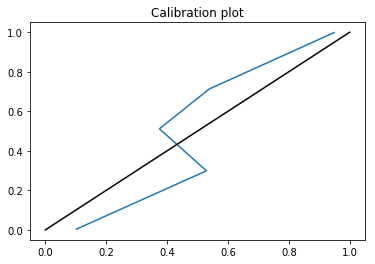

In [270]:
# bnn.model.l1.W_mu_DO.detach().numpy()
from sklearn.calibration import calibration_curve

n_bins = 5
calibration_mc_samples = 1000

sample_pred_list = []
for s in range(calibration_mc_samples):
    sample_pred = bnn.model(torch.tensor(X_train, dtype=torch.float), predict=True).detach().numpy()
    sample_pred_list.append(sample_pred)
    
# Each row is a sample, columns are datapoints; average across columns for probability
sample_preds = np.vstack(sample_pred_list).T
y_prob = np.mean(sample_preds, axis=1)
print(y_prob.shape, y_train.shape)
prob_true, prob_pred = calibration_curve(y_train, y_prob, n_bins=n_bins)

plt.plot(prob_true, prob_pred)
plt.plot([i/10 for i in range(0, 11)], [i /10 for i in range(0, 11)], c='black')
plt.title('Calibration plot')
plt.show()

In [850]:
preds = bnn.model(torch.tensor(X_test, dtype=torch.float), predict=True).detach().numpy()
fbeta_score(y_test, preds, 5)

0.9256256609094113

constant at 0.003 for classificaiton

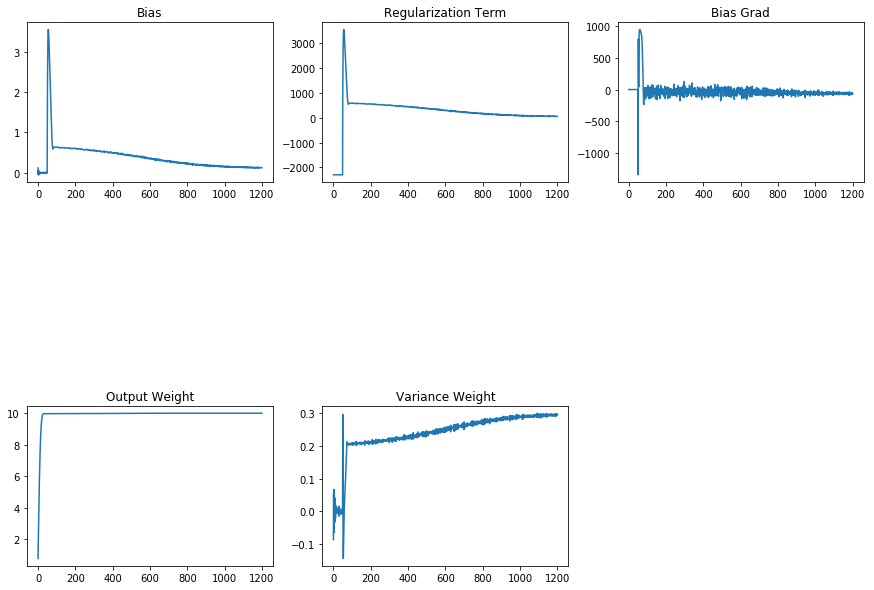

In [749]:
df = pd.read_csv("learned_variances_log.csv")
df

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(331)
ax.set_title('Bias')
ax.plot(df['b_2'])
ax = fig.add_subplot(332)
ax.set_title('Regularization Term')
ax.plot(df['reg'])
ax = fig.add_subplot(333)
ax.set_title('Bias Grad')
ax.plot(df['b_2_grad'])
ax = fig.add_subplot(337)
ax.set_title('Output Weight')
ax.plot(df['w1_2'])
ax = fig.add_subplot(338)
ax.set_title('Variance Weight')
ax.plot(df['w2_2'])
# plt.savefig(".png")


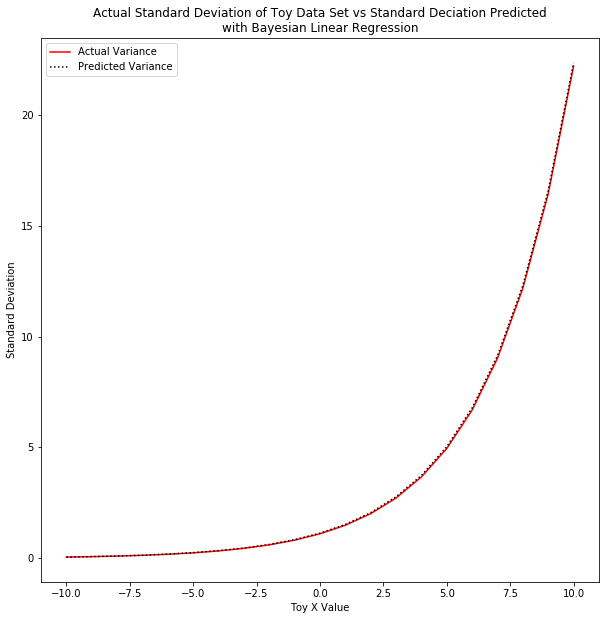

In [738]:
# W_s = np.array([0.0, 0.3]).reshape(-1, 1)
# print(W_s)
# b_s = 0.1

weights = bnn.model.l1.W_mu_DO.detach().numpy()
biases = bnn.model.l1.b_mu_O.detach().numpy()
variance_weight = weights[1][1]
bias = biases[1]
# sample_pred = bnn.model.forward(X_sample
                                

# predictions = bnn.model.forward(torch.Tensor(X_train))
# std_pred = torch.exp(predictions[:,1]).detach().numpy()

real_std = []
pred_std = []
for x in range(-10, 11):
    real_std.append(np.exp(0.3 * x + 0.1))
    pred_std.append(np.exp(variance_weight * x + bias ))
# print(real_std)
# fig, ax = plt.subplots(111, figsize=(10, 10))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Actual Standard Deviation of Toy Data Set vs Standard Deciation Predicted\nwith Bayesian Linear Regression')
ax.plot(list(range(-10, 11)), real_std, label='Actual Variance', c='red')
ax.plot(list(range(-10, 11)), pred_std, linestyle='dotted', label='Predicted Variance', c='black')
ax.legend()
ax.set_ylabel("Standard Deviation")
ax.set_xlabel("Toy X Value")
# plt.savefig(".png")
fig.show()
# plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
# plt.plot(std_pred, label='predicted')
# plt.title("Standard Deviation versus X value")

# plt.savefig("learned_variances.png")
# plt.xlim(right = 5

(5000,) (5000,)


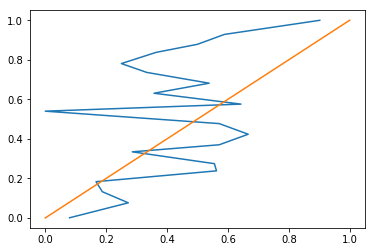

In [572]:
from sklearn.calibration import calibration_curve

n_bins = 20
calibration_mc_samples = 1000

sample_pred_list = []
for s in range(calibration_mc_samples):
    sample_pred = bnn.model(torch.tensor(X_train, dtype=torch.float), predict=True).detach().numpy()
    sample_pred_list.append(sample_pred)
    
# Each row is a sample, columns are datapoints; average across columns for probability
sample_preds = np.vstack(sample_pred_list).T
y_prob = np.mean(sample_preds, axis=1)
print(y_prob.shape, y_train.shape)
prob_true, prob_pred = calibration_curve(y_train, y_prob, n_bins=n_bins)

plt.plot(prob_true, prob_pred)
plt.plot([i/10 for i in range(0, 11)], [i /10 for i in range(0, 11)], c='black')
plt.title('Calibration plot')
plt.show()

torch.Size([150, 2])


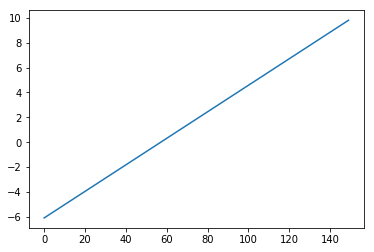

In [127]:
#X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T

X_sample = np.arange(-5, 10, .1)
X_sample = torch.tensor(
                    np.vstack([np.zeros(len(X_sample)), X_sample]).T,
                    dtype=torch.float32)

print(X_sample.shape)


sample_pred = bnn.model.forward(X_sample).detach().numpy()


plt.plot(list(range(len(X_sample))),
         sample_pred[:,1])
plt.show()

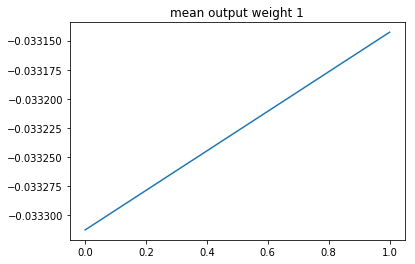

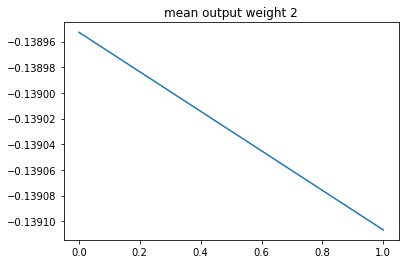

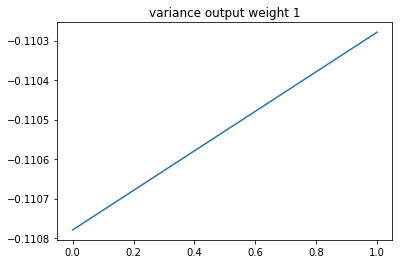

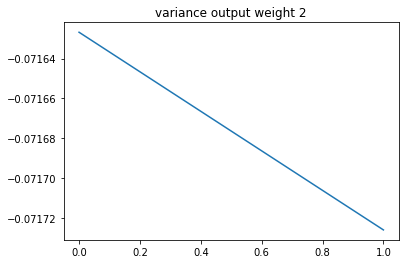

In [23]:
from graph_utils import *

df = pd.read_csv("1575743846.csv")


"""
w1_1,w1_2,w2_1,w2_2,
w1_1_grad,w1_2_grad,w2_1_grad,w2_2_grad,
b_1,b_2,
b_1_grad,b_2_grad
"""

graphCols(df, cols=['w1_1', 'w1_2', 'w2_1', 'w2_2'], ylabel='y', plotDim1=4, plotDim2=4)



In [ ]:
a = torch.normal(torch.tensor([0.0]*5), torch.tensor([5.0]*5))
print(a)

sig = nn.Sigmoid()
sig(a) > 0.5

bnn.likelihood_est(torch.tensor([0.0]*5), a, 0.1)

In [ ]:
for _ in range(10):
    pred1 = X_train @ W + b 
    pred2 = X_train @ W + b + np.random.normal(loc=0, scale=np.exp(X_train @ W_s + b_s))
    mae1 = np.mean(np.abs(pred1 - y_train))
    mae2 = np.mean(np.abs(pred2 - y_train))
    print("MAE 1: ", mae1, "MAE 2:", mae2)

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

final_pred = bnn.model.forward(torch.Tensor(X_train))
print(final_pred[:5,0])


pred_std = torch.exp(final_pred[:,1])

print(pred_std)
print(X_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:sparse_cap,0], X_train[:sparse_cap,1], pred_std[:sparse_cap].detach().numpy())
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')



# 2D Plot:
ax_2d_x = fig.add_subplot(312)
ax_2d_x.scatter(X_train[:,0], pred_std.detach().numpy())
ax_2d_x.set_xlabel('X_train[:,0]')
ax_2d_x.set_ylabel('output[:,1] (Standard Deviation)')


ax_2d_y = fig.add_subplot(313)
ax_2d_y.scatter(X_train[:,1], pred_std.detach().numpy())
ax_2d_y.set_xlabel('X_train[:,1]')
ax_2d_y.set_ylabel('output[:,1] (Standard Deviation)')



In [ ]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()

print(std_pred)

# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
  std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



"""
plt.scatter(X_train[:,0], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_train[:,0], y_train, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")
"""


plt.show()

# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()

In [ ]:
print(torch.exp(bnn.model.l1.W_log_s_DO))

In [ ]:

plt.plot([i for i in range(100)], loss_by_epoch)

In [ ]:
a = torch.tensor([3,3,3])
b = torch.tensor([5,5,3])
a == b

toy dataset classification 1d

In [348]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2), 0] = 0
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=2,
                                                 scale=1,
                                                 size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0



X_train[int(dataset_size/2):, 0] = 0
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=10,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [349]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

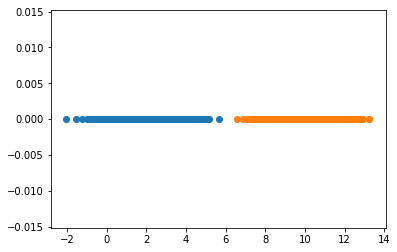

In [350]:
# a separating line!
# x1 = np.linspace(-2, 14, 20)
# y = x1 * 1 - 8.5

plt.scatter(X_train[y_train == 0, 1], [0]*int(X_train.shape[0]/2))
plt.scatter(X_train[y_train == 1, 1], [0]*int(X_train.shape[0]/2))

## test ELBO as slope of line changes

[[0. 0.]
 [1. 0.]]
[[0.]
 [1.]]
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b -19.819248
used_w 0.8899035
X_int 22.271233

used_b is -19.819248
used_w is  0.8899035

grads w1  tensor([ 1.0198e-02, -1.2547e+04])
grad b  tensor(-1282.3977)
Accuracy with -20 as bias:  50.0 %
likelihood -13418.05625
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b -18.864305
used_w 0.98585737
X_int 19.134924

used_b is -18.864305
used_w is  0.98585737

grads w1  tensor([-3.5752e-03, -1.3708e+04])
grad b  tensor(-1399.2957)
Accuracy with -19 as bias:  50.0 %
likelihood -12760.2975
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b -17.558372
used_w 1.0186613
X_int 17.236713

used_b is -17.558372
used_w is  1.0186613

grads w1  tensor([ 8.3697e-03, -1.6680e+04])
grad b  tensor(-1693.7307)
Accuracy with -18 as bias:  50.0 %
likelihood -13759.33
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b -16.737825
used_w 1.0964843
X_int 15.264993

used_b i


grads w1  tensor([2.9017e-03, 3.6801e+03])
grad b  tensor(1954.5815)
Accuracy with 9 as bias:  50.0 %
likelihood -20878.9025
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b 9.893426
used_w 1.0096751
X_int -9.798623

used_b is 9.893426
used_w is  1.0096751

grads w1  tensor([3.3065e-03, 3.9562e+03])
grad b  tensor(2062.0535)
Accuracy with 10 as bias:  50.0 %
likelihood -23511.645
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b 11.4332695
used_w 1.0774271
X_int -10.61164

used_b is 11.4332695
used_w is  1.0774271

grads w1  tensor([1.4228e-03, 3.8225e+03])
grad b  tensor(2016.8971)
Accuracy with 11 as bias:  50.0 %
likelihood -25235.1775
correct shape torch.Size([2, 1])
shape torch.Size([2, 1])
used_b 12.202447
used_w 1.0331433
X_int -11.810992

used_b is 12.202447
used_w is  1.0331433

grads w1  tensor([-1.1724e-02,  3.9175e+03])
grad b  tensor(2069.1858)
Accuracy with 12 as bias:  50.0 %
likelihood -27628.7825
correct shape torch.Size([2, 1])
shape to

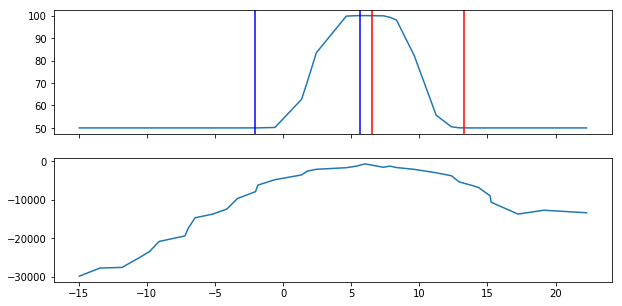

In [381]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b

# for regression toy set
# W_full = np.hstack((W, W_s))
# W_full

# b_full = np.hstack((b, b_s))
# b_full[1] = 2.0

# for 3d
# w1 = np.array([[0.0,1.0]]).T
# w2 = np.array([[0.0,0.0]]).T
# W_full = np.hstack((w1, w2))

# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)


w1 = np.array([[0.0,1.0]]).T
w2 = np.array([[0.0,0.0]]).T
W_full = np.hstack((w1, w2))
print(W_full)
print(w1)
# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)
mc_samples = [i * 20 for i in range(1, 11)]
bs = [i for i in range(-20, 15)]
used_bs = []
accuracies = []
x_ints = []
likelihoods = []
grad_bs = []
for b in bs:
    b_full = np.array([b,0])
    # b_full[0], b_full[1] = 0,0
#     bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
#                                     prior_s=0.8, 
#                                     linear_regression=True, 
#                                     classification=True,
#                                     preset={'W_mu': W_full, 'b_mu': b_full},
#                                     num_MC_samples=200)
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                    prior_s=0.8, 
                                    linear_regression=True, 
                                    classification=True,
                                    preset=False,
                                    num_MC_samples=100)
    print('correct shape', bnn_preset.model.mu_layers[0].W_mu_DO.size())
    print('shape', torch.tensor([[0], [1]]).size())
    bnn_preset.model.mu_layers[0].W_mu_DO = nn.Parameter(torch.Tensor([[0], [1]]))
    bnn_preset.model.mu_layers[0].W_log_s_DO = nn.Parameter(torch.Tensor([[-3], [-3]])) 

    bnn_preset.model.mu_layers[0].b_mu_O = nn.Parameter(torch.Tensor([b]))
    bnn_preset.model.mu_layers[0].b_log_s_O = nn.Parameter(torch.Tensor([-1])) 
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train), predict=True).detach().numpy()
    used_b = bnn_preset.model.mu_layers[0].usedBias[0].detach().numpy()
    used_w = bnn_preset.model.mu_layers[0].usedWeights[1][0].detach().numpy()
    print('used_b', used_b)
    print('used_w', used_w)
    used_bs.append(used_b)
    
    x_intercept = -used_b / used_w
    x_ints.append(x_intercept)
    print('X_int', x_intercept)
    print('\nused_b is', used_b)
    print('used_w is ', used_w)
    
    bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()
    acc = np.mean((preset_preds == y_train.flatten()).astype(int)) * 100
    accuracies.append(acc)
    print('Accuracy with {} as bias: '.format(b), acc, '%')
    
    likelihood = bnn_preset.mean_likelihood
    likelihoods.append(likelihood)
    print('likelihood', likelihood)
    
    grad_bs.append(bnn_preset.gradB)
 
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')

# ax[0].scatter([np.min(X_train[y_train == 1, 1]), np.max(X_train[y_train == 1, 1])], [50,50], c='red')


ax[1].plot(x_ints, likelihoods)
print('class 0 min: ', np.min(X_train[y_train == 0, 1]))
print('class 0 max: ',np.max(X_train[y_train == 0, 1]))
print('class 1 min: ', np.min(X_train[y_train == 1, 1]))
print('class 1 max: ',np.max(X_train[y_train == 1, 1]))



In [382]:
# # nesting subplots in subplots for MC sampling model selection?

# fig = plt.figure(figsize=(20, 20))
# outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

# for i in range(9):
#     inner = gridspec.GridSpecFromSubplotSpec(3, 1,
#                     subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    
#     for j in range(3):
#         ax = plt.Subplot(fig, inner[j])
# #         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
# #         t.set_ha('center')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         fig.add_subplot(ax)
        
# fig.show()
# grad_bs

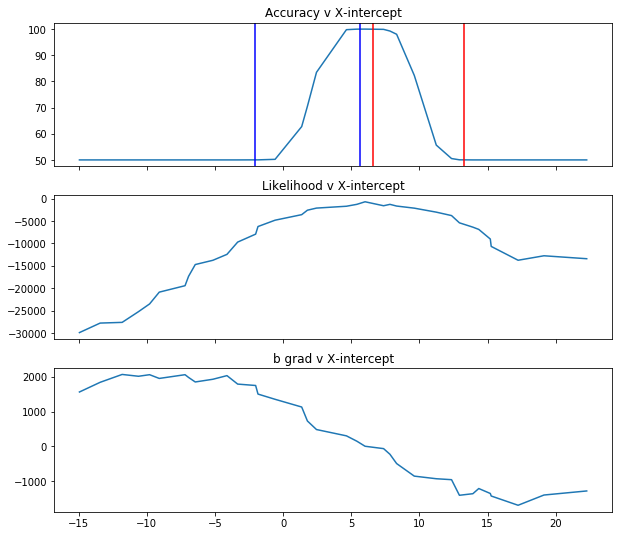

In [383]:


fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v X-intercept')
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v X-intercept')
ax[1].plot(x_ints, likelihoods)

ax[2].set_title('b grad v X-intercept')
ax[2].plot(x_ints, grad_bs)

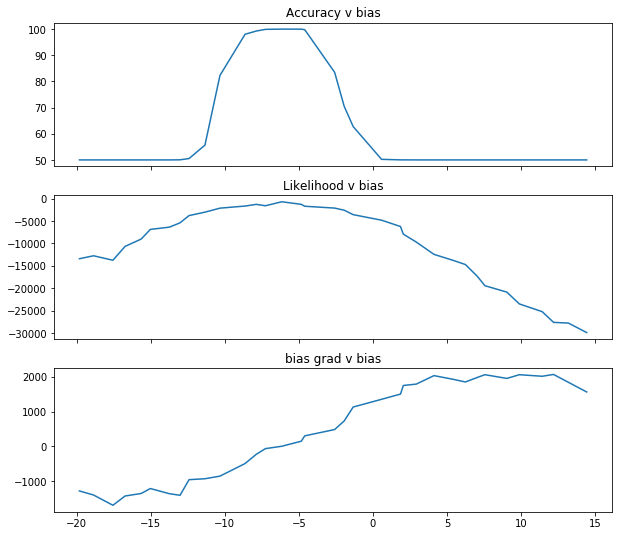

In [384]:
fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v bias')
ax[0].plot(used_bs, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
# ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
# ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

# ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
# ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v bias')
ax[1].plot(used_bs, likelihoods)

ax[2].set_title('bias grad v bias')
ax[2].plot(used_bs, grad_bs)

In [449]:
bnn = BNNBayesbyBackprop(input_dim=2, core_hidden_layers=[5], mu_hidden_layers=[3], log_s_hidden_layers=[3], 
                         prior_mu=0.0, prior_s=1.0, num_MC_samples=100, preset=False, classification=True)
print('\nCORE LAYERS')
for i, layer_i in enumerate(bnn.model.core_layers):
    print("LAYER {}\t INPUT DIM: {}\t OUTPUT DIM: {}".format(i, layer_i.input_dim, layer_i.output_dim))

print('\nMU LAYERS')
for i, layer_i in enumerate(bnn.model.mu_layers):
    print("LAYER {}\t INPUT DIM: {}\t OUTPUT DIM: {}".format(i, layer_i.input_dim, layer_i.output_dim))

print('\nLOG S LAYERS')
for i, layer_i in enumerate(bnn.model.log_s_layers):
    print("LAYER {}\t INPUT DIM: {}\t OUTPUT DIM: {}".format(i, layer_i.input_dim, layer_i.output_dim))



CORE LAYERS

MU LAYERS
LAYER 0	 INPUT DIM: 2	 OUTPUT DIM: 1

LOG S LAYERS
LAYER 0	 INPUT DIM: 2	 OUTPUT DIM: 1


In [450]:
bnn.fit(X_train, y_train, plot=True, n_epochs=100, learning_rate=2, batch_size=1000)

Data being saved in following file:
logging.csv
Epoch:  0 	Loss:  5905.5522 	acc:  0.9996
Epoch:  1 	Loss:  770.38544 	acc:  0.996
Epoch:  2 	Loss:  780.8076 	acc:  0.9508
Epoch:  3 	Loss:  1013.2091 	acc:  0.9904
Epoch:  4 	Loss:  758.27795 	acc:  0.9998
Epoch:  5 	Loss:  770.7533 	acc:  1.0
Epoch:  6 	Loss:  763.34644 	acc:  0.9998
Epoch:  7 	Loss:  707.55286 	acc:  0.9998
Epoch:  8 	Loss:  608.4663 	acc:  1.0


KeyboardInterrupt: 

In [448]:
pd.read_csv('logging.csv')

,mu_l0_w00,mu_l0_w10,log_s_l0_w00,log_s_l0_w10,log_prior,log_posterior,mean_likelihood,reg
0,-1.294010,1.007700,1.385109,-1.285824,-15.821725,-8.910430,-694.643438,-2302.582188
1,1.010893,2.559515,-1.072773,0.994470,-42.727070,-8.679141,-57.472871,-2302.582188
2,-0.770588,3.617441,0.754161,-0.758603,-70.127275,-8.396108,-223.644082,-2302.582188
3,0.471424,3.351561,-0.378890,0.474744,-105.166230,-8.397952,-41.141782,-2302.582188


In [628]:
X_train1 = X_train
y_train1 = y_train

accuracies = []
weights = [0.0, 0.1, 0.5, 1.0, 3.0, 5.0, 5.5, 6.0, 7.0, 10.0]
for w in weights:
#     w1 = np.array([0, w])
    W_full[0][0] = w
    print('weights: ', W_full[0])
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                prior_s=0.8, 
                                linear_regression=True, 
                                classification=True,
                                preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train1), predict=True).detach().numpy()
    print('ELBO components with {} as slope: \n'.format(w))
    bnn_preset.MC_elbo(torch.Tensor(X_train1), torch.Tensor(y_train1), 9, 10, 100).detach().numpy()
    print('Accuracy with {} as slope: '.format(w), np.mean((preset_preds == y_train1.flatten()).astype(int)) * 100, '%')
    
    Z = plane(X1, X2, W_full[0], b)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(311, projection='3d') 
    ax.set_title("line with {} as slope".format(w))

    ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
    ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
    ax.plot_wireframe(X1, X2, Z, color='grey', alpha = 0.99)

#     fig.show()
    plt.show()
#     x1 = np.random.uniform(-8, 8, 100)
#     x2 = w * x1

#     plt.title("line with {} as slope".format(w))
#     plt.plot(x1, x2)
#     plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
#     plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
#     plt.ylim((-10, 10))
    

weights:  [0 0]
ELBO components with 0.0 as slope: 



IndexError: too many indices for tensor of dimension 1